# Counter-Strike ML - Round Swing on Major Games

This notebook is a machine learning personal project by [sadhubby](https://github.com/sadhubby) that analyses professional Counter Strike games during the StarLadder Budapest 2025 Major Playoffs and calculates round swing on actions done across the map each round.

As a high-level example, this is similar to Chess.com's move analyzer that calculates the possibility of winning for either black or white based on the move done by the player.

The intended use of this machine learning software is to be able to analyze one's own personal games in Counter-Strike, whether through Valve's matchmaking or FaceIt's third-party matchmaking. This is so that the user will have numerical and graphical evidence of how great an impact a certain action is to the round as a whole. 

First, importing [pandas](https://pandas.pydata.org/) library for data analysis and [awpy](https://github.com/pnxenopoulos/awpy) for the gathering the data from recorded professional Counter Strike games during the Major. The video files are taken from [HLTV](https://www.hltv.org/), a website for Counter Strike News and Coverage. They include the recorded videos, called match demos, for every game done during the Major. 

In [46]:
import pandas as pd
import numpy as np
from demoparser2 import DemoParser
import matplotlib.pyplot as plt
import os
import glob

Before anything, it is first best to test this on a single map of a match. For the purpose of testing, Map 2 of the match between Vitality and FaZe Clan during the Grand Finals of StarLadder Budapest Major 2025.

Here, we first create a Demo instance of a match and parsing the instance. Let's use the second map of Vitality vs Faze in the Grand Finals.

In [47]:
demo_folder = "/home/moonberry/Downloads/cs2_demos_budapest_major"
demo_files = glob.glob(os.path.join(demo_folder, "*.dem"))
print(f"Found {len(demo_files)} demos to process.")

Found 16 demos to process.


In [48]:
# parser = DemoParser("vitality-vs-faze-m2-dust2.dem")

Let's now get the macro-level events, such as round start, round end and bomb plants and defuses.

In [49]:
def get_clean_df(event_list, name):
    for event_name, df in event_list:
        if event_name == name:
            if not df.empty:
                df['tick'] = pd.to_numeric(df['tick'], errors='coerce')
                if 'winner' in df.columns:
                    df['winner'] = pd.to_numeric(df['winner'], errors='coerce')
            return df
    return pd.DataFrame()

def create_team_snapshots(df):
    # Vectorized team stats calculation
    df['ct_hp_val'] = np.where(df['team_num'] == 3, df['health'], 0)
    df['t_hp_val'] = np.where(df['team_num'] == 2, df['health'], 0)
    df['ct_alive_val'] = np.where((df['team_num'] == 3) & (df['is_alive']), 1, 0)
    df['t_alive_val'] = np.where((df['team_num'] == 2) & (df['is_alive']), 1, 0)
    
    # Aggregation
    snapshots = df.groupby('tick').agg(
        ct_alive=('ct_alive_val', 'sum'),
        t_alive=('t_alive_val', 'sum'),
        ct_hp=('ct_hp_val', 'sum'),
        t_hp=('t_hp_val', 'sum'),
        # Note: This lambda is slow for huge datasets, but fine for standard analysis
        ct_val=('equipment_value_this_round', lambda x: df.loc[x.index[df.loc[x.index, 'team_num'] == 3], 'equipment_value_this_round'].sum()),
        t_val=('equipment_value_this_round', lambda x: df.loc[x.index[df.loc[x.index, 'team_num'] == 2], 'equipment_value_this_round'].sum())
    ).reset_index()
    return snapshots

def label_data(snapshots_df, rounds_df):
    """
    Labels a SINGLE demo's dataframe with the winner.
    Must be done before concatenating multiple demos.
    """
    df = snapshots_df.copy()
    df['ct_win_label'] = np.nan
    rounds_sorted = rounds_df.sort_values('tick')
    
    last_tick = 0
    for _, row in rounds_sorted.iterrows():
        # Winner: 3 is CT, 2 is T. Label 1 if CT won, 0 if T won.
        winner_label = 1 if row['winner'] == 3 else 0
        
        mask = (df['tick'] > last_tick) & (df['tick'] <= row['tick'])
        df.loc[mask, 'ct_win_label'] = winner_label
        last_tick = row['tick']
        
    return df.dropna(subset=['ct_win_label'])

In [50]:
all_training_data = []
match_database = {} # To store raw round data for plotting later

wanted_props = ["health", "is_alive", "team_num", "equipment_value_this_round"]

for file_path in demo_files:
    filename = os.path.basename(file_path)
    print(f"Processing: {filename}...")
    
    try:
        parser = DemoParser(file_path)
        
        # A. Parse Events
        raw_events = parser.parse_events(["round_end", "round_freeze_end"])
        rounds_end = get_clean_df(raw_events, "round_end").dropna(subset=['tick'])
        rounds_start = get_clean_df(raw_events, "round_freeze_end").dropna(subset=['tick'])
        
        # B. Parse Ticks
        df_ticks = parser.parse_ticks(wanted_props)
        
        # C. Feature Engineering
        snapshots = create_team_snapshots(df_ticks)
        
        # D. Labeling (Crucial: Do this PER DEMO)
        labeled_df = label_data(snapshots, rounds_end)
        
        # Add metadata so we can distinguish matches later
        labeled_df['match_id'] = filename
        snapshots['match_id'] = filename 
        
        # Store for training
        all_training_data.append(labeled_df)
        
        # Store for plotting (we need the raw round/start end times)
        match_database[filename] = {
            "snapshots": snapshots, # Unlabeled/full snapshots for plotting
            "rounds_end": rounds_end,
            "rounds_start": rounds_start
        }
        
    except Exception as e:
        print(f"Failed to process {filename}: {e}")

Processing: vitality-vs-faze-m4-overpass.dem...
Processing: vitality-vs-the-mongolz-m2-dust2.dem...
Processing: furia-vs-natus-vincere-m2-inferno.dem...
Processing: vitality-vs-faze-m1-nuke.dem...
Processing: vitality-vs-faze-m3-inferno.dem...
Processing: vitality-vs-the-mongolz-m1-mirage.dem...
Processing: spirit-vs-falcons-m2-dust2.dem...
Processing: furia-vs-natus-vincere-m3-train.dem...
Processing: spirit-vs-vitality-m1-mirage.dem...
Processing: spirit-vs-falcons-m1-nuke.dem...
Processing: spirit-vs-vitality-m2-dust2.dem...
Processing: faze-vs-natus-vincere-m2-nuke.dem...
Processing: furia-vs-natus-vincere-m1-mirage.dem...
Processing: faze-vs-natus-vincere-m1-ancient.dem...
Processing: vitality-vs-faze-m2-dust2.dem...
Processing: faze-vs-natus-vincere-m3-inferno.dem...


In [61]:
train_df = pd.concat(all_training_data, ignore_index=True)
print(f"\nTotal training ticks collected: {len(train_df)}")

features = ['ct_alive', 't_alive', 'ct_hp', 't_hp', 'ct_val', 't_val']

# Check for both classes
unique_winners = train_df['ct_win_label'].unique()
if len(unique_winners) < 2:
    print("⚠️ WARNING: Your dataset still only has one winner type. Add more balanced demos.")
else:
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(train_df[features], train_df['ct_win_label'])


Total training ticks collected: 2970961
⚠️ WARNING: Your dataset still only has one winner type. Add more balanced demos.


In [72]:
def plot_round_swing(match_name, round_index, model):
    if match_name not in match_database:
        print(f"Match {match_name} not found.")
        return

    data = match_database[match_name]
    snapshots_df = data['snapshots']
    rounds_end_df = data['rounds_end']
    rounds_start_df = data['rounds_start']

    if round_index >= len(rounds_end_df):
        print(f"Round {round_index} does not exist in {match_name}")
        return

    end_tick = rounds_end_df.iloc[round_index]['tick']
    
    # Get start tick
    if not rounds_start_df.empty:
        possible_starts = rounds_start_df[rounds_start_df['tick'] < end_tick]['tick']
        start_tick = possible_starts.max() if not possible_starts.empty else 0
    else:
        start_tick = rounds_end_df.iloc[round_index-1]['tick'] if round_index > 0 else 0

    # Filter ticks for this specific round
    round_data = snapshots_df[(snapshots_df['tick'] >= start_tick) & (snapshots_df['tick'] <= end_tick)].copy()
    
    if round_data.empty: return

    proba = model.predict_proba(round_data[features])

# If model has 2 classes (normal behavior), take the second column
    if proba.shape[1] == 2:
        probs = proba[:, 1]
# If model only knows class 0, probability of class 1 is 0.0
    elif model.classes_[0] == 0:
        probs = np.zeros(proba.shape[0])
# If model only knows class 1, probability of class 1 is 1.0
    else:
        probs = np.ones(proba.shape[0])

    plt.figure(figsize=(15, 2))
    plt.fill_between(range(len(probs)), probs, 0.5, where=(probs >= 0.5), color='#5d79ae', alpha=0.6, label='CT Adv') # CT Blue
    plt.fill_between(range(len(probs)), probs, 0.5, where=(probs < 0.5), color='#de9b35', alpha=0.6, label='T Adv')   # T Orange
    plt.axhline(0.5, color='gray', linestyle='--', linewidth=0.8)
    plt.plot(probs, color='black', linewidth=1)
    plt.title(f"{match_name} - Round {round_index + 1}")
    plt.ylim(0, 1)
    plt.yticks([0, 0.5, 1], ['T Win', 'Even', 'CT Win'])
    plt.xlabel('Ticks (Time)')
    plt.tight_layout()
    plt.show()

In [73]:
print(model.classes_)

[0.]


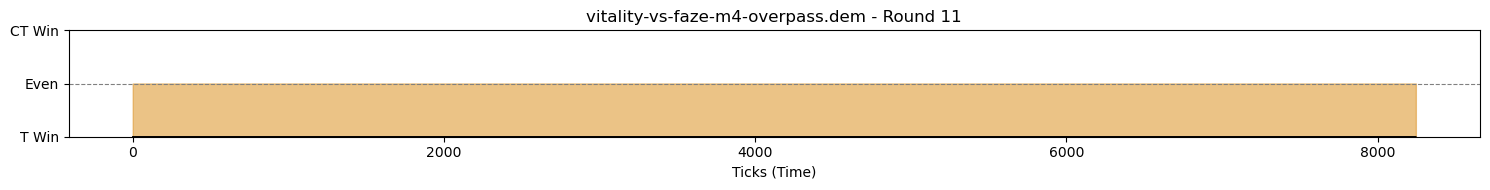

In [76]:
first_match = os.path.basename(demo_files[0])
plot_round_swing(first_match, 10, model)

In [53]:
# # 1. Extract Events
# raw_events = parser.parse_events(["round_end", "round_freeze_end", "bomb_planted"])

# def get_clean_df(event_list, name):
#     for event_name, df in event_list:
#         if event_name == name:
#             # Ensure tick and winner are numeric
#             if not df.empty:
#                 df['tick'] = pd.to_numeric(df['tick'], errors='coerce')
#                 if 'winner' in df.columns:
#                     df['winner'] = pd.to_numeric(df['winner'], errors='coerce')
#             return df
#     return pd.DataFrame()

# rounds_end = get_clean_df(raw_events, "round_end").dropna(subset=['tick'])
# rounds_start = get_clean_df(raw_events, "round_freeze_end").dropna(subset=['tick'])
# bomb_plants = get_clean_df(raw_events, "bomb_planted")

# # 2. Extract Player Ticks (Every 64 ticks)
# # wanted_props as per documentation
# wanted_props = ["health", "is_alive", "team_num", "equipment_value_this_round"]
# df_ticks = parser.parse_ticks(wanted_props)

# print(f"Extraction complete: {len(rounds_end)} round ends found.")

In [54]:
# def create_team_snapshots(df):
#     # Vectorized team stats calculation
#     df['ct_hp_val'] = np.where(df['team_num'] == 3, df['health'], 0)
#     df['t_hp_val'] = np.where(df['team_num'] == 2, df['health'], 0)
#     df['ct_alive_val'] = np.where((df['team_num'] == 3) & (df['is_alive']), 1, 0)
#     df['t_alive_val'] = np.where((df['team_num'] == 2) & (df['is_alive']), 1, 0)
    
#     snapshots = df.groupby('tick').agg(
#         ct_alive=('ct_alive_val', 'sum'),
#         t_alive=('t_alive_val', 'sum'),
#         ct_hp=('ct_hp_val', 'sum'),
#         t_hp=('t_hp_val', 'sum'),
#         ct_val=('equipment_value_this_round', lambda x: df.loc[x.index[df.loc[x.index, 'team_num'] == 3], 'equipment_value_this_round'].sum()),
#         t_val=('equipment_value_this_round', lambda x: df.loc[x.index[df.loc[x.index, 'team_num'] == 2], 'equipment_value_this_round'].sum())
#     ).reset_index()
#     return snapshots

# snapshots = create_team_snapshots(df_ticks)

In [55]:
# from sklearn.ensemble import RandomForestClassifier

# def label_for_ml(snapshots_df, rounds_df):
#     df = snapshots_df.copy()
#     df['ct_win_label'] = np.nan
#     rounds_sorted = rounds_df.sort_values('tick')
    
#     last_tick = 0
#     for _, row in rounds_sorted.iterrows():
#         winner_label = 1 if row['winner'] == 3 else 0
#         mask = (df['tick'] > last_tick) & (df['tick'] <= row['tick'])
#         df.loc[mask, 'ct_win_label'] = winner_label
#         last_tick = row['tick']
#     return df.dropna(subset=['ct_win_label'])

# train_data = label_for_ml(snapshots, rounds_end)
# features = ['ct_alive', 't_alive', 'ct_hp', 't_hp', 'ct_val', 't_val']

# # Check classes before fitting
# unique_winners = train_data['ct_win_label'].unique()
# if len(unique_winners) < 2:
#     print("⚠️ WARNING: Only one team won in this demo. The 'Swing Bar' will not work correctly.")
#     print("Try adding more demo files to your training set to see both CT and T wins.")

# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(train_data[features], train_data['ct_win_label'])